## Import Libraries

In [126]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

import re # regular expression
import random
from itertools import groupby

# select plot style
plt.style.use('fivethirtyeight')

## Load Dataset


In [2]:
# we only want the training partition
dataset_raw = tfds.load("tiny_shakespeare")['train']

Shuffling and writing examples to /root/tensorflow_datasets/tiny_shakespeare/1.0.0.incompleteKCRXF3/tiny_shakespeare-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/tiny_shakespeare/1.0.0.incompleteKCRXF3/tiny_shakespeare-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/tiny_shakespeare/1.0.0.incompleteKCRXF3/tiny_shakespeare-test.tfrecord


Dataset tiny_shakespeare downloaded and prepared to /root/tensorflow_datasets/tiny_shakespeare/1.0.0. Subsequent calls will reuse this data.


## Preprocess Dataset

In [3]:
# Convert dataset into one string
dataset_as_string = [elem['text'].numpy().decode("utf-8") for elem in dataset_raw][0]
print(type(dataset_as_string))

<class 'str'>


In [4]:
# Remove new-line-characters
print("Before:\n", repr(dataset_as_string[0:40]))
str_1 = re.sub(r'\n', ' ', dataset_as_string) 
print("After:\n", repr(str_1[0:40]))

Before:
 'First Citizen:\nBefore we proceed any fur'
After:
 'First Citizen: Before we proceed any fur'


In [5]:
# Remove Special Characters and convert to lower case
i = str_1.find("&")
reference = str_1[i+10:i+20]
print("Before:\n", repr(str_1[i-20:i+20]))
str_2 = re.sub(r'[^a-z0-9 ]+', '', str_1.lower())
i = str_2.find(reference)
print("After:\n", repr(str_2[i-25:i+20]))

Before:
 "ld goat!  Senators, &C: We'll surety him"
After:
 'ld goat  senators c well surety him  cominius'


In [6]:
# Split String into word tokens and remove empty tokens ''
print("Before:\n", str_2[0:20])
word_data = str_2.split(" ")
word_data = [word for word in word_data if word != '']
print("After:\n", word_data[0:3])

Before:
 first citizen before
After:
 ['first', 'citizen', 'before']


In [47]:
# Create ID dicts
word_to_id = {}
id_to_word = {}

for id, word in enumerate(set(word_data)):
    word_to_id[word] = id
    id_to_word[id] = word

In [52]:
# Create Frequency dict
word_to_frequency = {}

for word in word_data:
    if word in word_to_frequency:
        word_to_frequency[word] += 1
    else:
        word_to_frequency[word] = 1

total_word_num = len(word_data)
word_to_frequency = {word: n/total_word_num for word, n in word_to_frequency.items()}


In [53]:
word_to_frequency["the"]

0.031332536960119235

In [54]:
def subsample(word, s = 0.001):
    z_w = word_to_frequency[word]
    return (np.sqrt(z_w/s) + 1) * (s/z_w)

In [77]:
subsample("tree")

42.54022367327437

In [113]:
# Create Dataset with target context pairs [target_word, context_word] with subsampling
context_window = 4

positive_pairs = []

positive_pairs_int = []

# stored as ids
word_to_context = {}

for i, word in enumerate(word_data):
    for ii in range(1, context_window+1):
        if (i - ii) > 0 and (i + ii) < total_word_num:

            target_subsample_prob = subsample(word)
            if np.random.random() < target_subsample_prob:

                context_left = word_data[i-ii]
                context_left_subsample_prob = subsample(context_left)
                if np.random.random() < context_left_subsample_prob:
                    positive_pairs.append([word, context_left])
                    positive_pairs_int.append([word_to_id[word], word_to_id[context_left], 1])
                    try:
                        word_to_context[word_to_id[word]] += [word_to_id[context_left]]
                    except KeyError:
                        word_to_context[word_to_id[word]] = [word_to_id[context_left]]

                context_right = word_data[i+ii]
                context_right_subsample_prob = subsample(context_right)
                if np.random.random() < context_right_subsample_prob:
                    positive_pairs.append([word, context_right])
                    positive_pairs_int.append([word_to_id[word], word_to_id[context_right], 1])
                    try:
                        word_to_context[word_to_id[word]] += [word_to_id[context_right]]
                    except KeyError:
                        word_to_context[word_to_id[word]] = [word_to_id[context_right]]
            

In [114]:
print(len(positive_pairs))
positive_pairs[0:10]

852020


[['before', 'citizen'],
 ['before', 'we'],
 ['we', 'before'],
 ['we', 'proceed'],
 ['we', 'citizen'],
 ['we', 'any'],
 ['proceed', 'we'],
 ['proceed', 'any'],
 ['proceed', 'before'],
 ['proceed', 'further']]

In [115]:
positive_pairs_int[0:10]

[[5608, 1347, 1],
 [5608, 1696, 1],
 [1696, 5608, 1],
 [1696, 9157, 1],
 [1696, 1347, 1],
 [1696, 7422, 1],
 [9157, 1696, 1],
 [9157, 7422, 1],
 [9157, 5608, 1],
 [9157, 8995, 1]]

## Negative Sampling

In [116]:
# This may take some time
# increase subsampling parameter for faster performance
s = 20

# For each pair we want to include n negative samples
# a negative context word is more likely to appear if it has a higher frequency in the corpus
n = 2

word_num = len(word_to_id)

negative_pairs_int = []

for pair in positive_pairs_int:
    for i in range(n):
        valid_sample = False
        while not valid_sample:
            potential_sample = np.random.randint(0,word_num)
            # check if sample is context word of target
            if potential_sample not in word_to_context[pair[0]]:
                # if sample really is a negative context word
                # we decide if we want to select it based on its frequency in the corpus
                # for that we just use and adjusted inverse subsampling (increase scaler for faster runtime)
                potential_sample_freq = s/subsample(id_to_word[potential_sample])
                if np.random.random() < potential_sample_freq:
                    negative_pairs_int.append([pair[0], potential_sample, 0])
                    valid_sample = True



In [117]:
negative_pairs_int[0:10]

[[5608, 9479, 0],
 [5608, 294, 0],
 [5608, 10331, 0],
 [5608, 6432, 0],
 [1696, 4505, 0],
 [1696, 2799, 0],
 [1696, 5590, 0],
 [1696, 2767, 0],
 [1696, 11790, 0],
 [1696, 2152, 0]]

In [118]:
for pair in negative_pairs_int[0:10]:
    print(id_to_word[pair[0]], id_to_word[pair[1]])

before actions
before fallible
before husbands
before discretion
we departure
we caught
we properly
we hunting
we wide
we melt


## Create Dataset

In [132]:
# Concatinate positive and negative samples and shuffle them
target_input_pairs = positive_pairs_int + negative_pairs_int
random.shuffle(target_input_pairs)

In [131]:
dataset = tf.data.Dataset.from_tensor_slices(target_input_pairs)

i = 0
for elem in dataset:
    print(elem)
    if i == 10:
        break
    i+=1

batch_size = 64
dataset = dataset.batch(batch_size)

tf.Tensor([9938 9053    0], shape=(3,), dtype=int32)
tf.Tensor([7319 9822    0], shape=(3,), dtype=int32)
tf.Tensor([11555 10850     1], shape=(3,), dtype=int32)
tf.Tensor([6452 4846    1], shape=(3,), dtype=int32)
tf.Tensor([5373 6392    0], shape=(3,), dtype=int32)
tf.Tensor([8341 6516    1], shape=(3,), dtype=int32)
tf.Tensor([7419 8696    0], shape=(3,), dtype=int32)
tf.Tensor([7079 1441    0], shape=(3,), dtype=int32)
tf.Tensor([2709 6661    1], shape=(3,), dtype=int32)
tf.Tensor([4760 2825    0], shape=(3,), dtype=int32)
tf.Tensor([2022 1035    0], shape=(3,), dtype=int32)


## SkipGram

In [ ]:
class SkipGram(Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = Embedding(vocab_size, 
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding", )
    self.context_embedding = Embedding(vocab_size, 
                                       embedding_dim, 
                                       input_length=num_ns+1)
    self.dots = Dot(axes=(3,2))
    self.flatten = Flatten()

  def call(self, pair):
    target, context = pair
    we = self.target_embedding(target)
    ce = self.context_embedding(context)
    dots = self.dots([ce, we])
    return self.flatten(dots)


In [ ]:
class SkipGram(Layer):
    def __init__(self, embedding_size = 100, input_dim = len(word_to_id)):
        super(SkipGram, self).__init__()

        self.embedding_size = embedding_size
        self.input_dim = input_dim


    def build(self, input_shape):
        self.embeddings = self.add_weight("embedding matrix", shape=[self.input_dim, self.embedding_size])
        
        self.nce_weights = self.add_weight('nce weights', shape=[self.input_dim, self.embedding_size])
        self.nce_biases =  tf.Variable(tf.zeros([self.input_dim]))


    def call(self, x):
        embeddings = tf.nn.embedding_lookup(self.embeddings, x[:,0])
        labels = tf.expand_dims(x[:,1], -1)

        loss = tf.reduce_mean(
                    tf.nn.nce_loss(
                              weights = self.nce_weights,
                              biases = self.nce_biases,
                              labels = labels,
                              inputs = embeddings,
                              num_sampled = 2,
                              num_classes = self.input_dim))
        
        return loss




In [ ]:
test_gram = SkipGram()

for elem in dataset:
    a = elem
    break

test_gram(a)

<tf.Tensor: shape=(), dtype=float32, numpy=52.846924>

## Train SkipGram

In [ ]:
def train_step(model, data, optimizer):
    with tf.GradientTape() as tape:
        loss = model(data)
        gradients = tape.gradient(loss, model.trainable_variables)
       
        # if the distance between prediction and label is < 0.5 
        # for the respective query elements we say the prediction is correct
        # accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.greater(pred,0.5), tf.equal(label,1)), dtype=tf.float32))
        
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

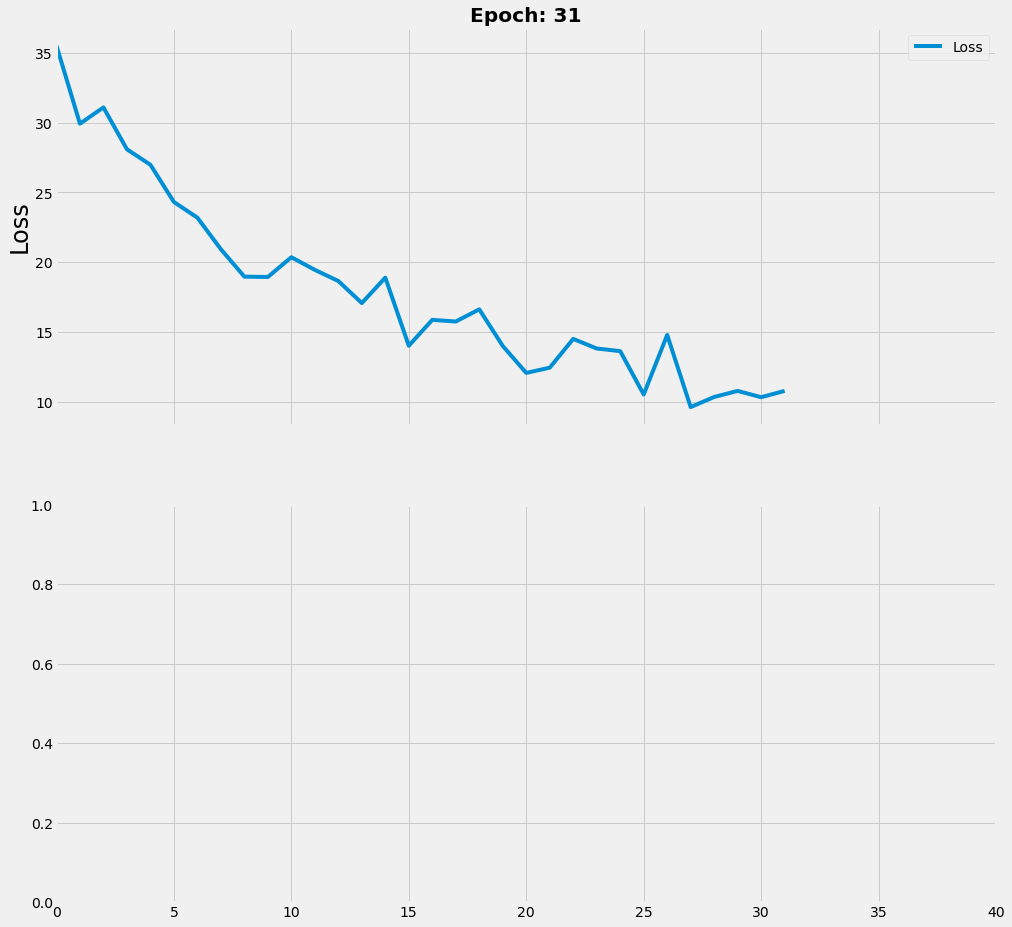

Epoch: __ 32


KeyboardInterrupt: ignored

In [ ]:
tf.keras.backend.clear_session()
from IPython.display import clear_output

num_epochs = 40
learning_rate = 0.001
embedding_size = 20
running_average_factor = 0.95

skip_gram = SkipGram(embedding_size)

optimizer = tf.keras.optimizers.Adam(learning_rate)

losses = []

for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    running_average_loss = 0
    for data in dataset:
        loss = train_step(skip_gram, data, optimizer)
        running_average_loss = np.mean((running_average_factor * running_average_loss  + (1 - running_average_factor) * loss).numpy())
        
    losses.append(running_average_loss)
    

    # Plotting
    clear_output(wait=True) 
    fontsize=24

    fig, ax = plt.subplots(2,1,sharex=True,figsize=(15,15))

    ax[0].set_xlim((0,num_epochs))
    ax[0].plot(losses,label="Loss")
    
    ax[0].set_ylabel("Loss",fontsize=fontsize)
    ax[0].set_title("Epoch: " + str(epoch), fontweight="bold")
    ax[0].legend()

    plt.show()
